In [1]:
def __clear_env():
    for key in globals().keys():
        if not key.startswith("__"):# 排除系统内建函数
            globals().pop(key)
__clear_env
import example_pendulum
import torch; torch.manual_seed(66)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
#import torchvision
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import datetime
from torch.autograd import Variable

1.6073796015734873e-65


In [2]:
file_route = R'/mnt/ssd1/stilrmy/Autoencoder-conservtive_expression/progress/AE'
device = 'cuda:0'
data = example_pendulum.get_pendulum_data(20)
val_data = example_pendulum.get_pendulum_data(10)
save_params = True
load_params = False

load_date = str(datetime.date.today())
load_ver = 1
widths = [512,128,64]
params={}
params['ver'] = "1"
params['accumulate_epochs'] = 0
params['date'] = '4-21'
params['widths'] = widths
params['activation'] = 'sigmoid'
params['max_epochs'] = 40000
params['epoch_size'] = data["x"].shape[0]
params['batch_size'] = 500
params['learning_rate'] = 0
params['loss_weight_x'] = 1
params['loss_weight_dx'] = 1
params['loss_weight_ddx'] = 1
params['learning_rate_switching_point'] = 500
loss_history = []
loss_z_history = []


In [3]:
params['learning_rate_stage1'] = 1e-6
params['learning_rate_stage2'] = 1e-6
params['learning_rate'] = params['learning_rate_stage1']

In [4]:
def autoencoder(input_dim,latent_dim,widths,device):
    #generate the parameters of the autoencoder
    encoder_weights,encoder_biases = build_network_layers(input_dim,latent_dim,widths,device)
    decoder_weights, decoder_biases = build_network_layers(latent_dim, input_dim, widths[::-1],device)
    return encoder_weights,encoder_biases,decoder_weights,decoder_biases


In [5]:
def build_network_layers(input_dim,output_dim,widths,device):
    #universal function for building network
    weights = []
    biases = []
    last_width = input_dim
    #middle layers
    for i,n_units in enumerate(widths):
        w = torch.Tensor(last_width,n_units,).to(device)
        nn.init.xavier_uniform_(w, gain=1.0)
        w = Variable(w, requires_grad=True)
        b = torch.Tensor(n_units).to(device)
        nn.init.constant_(b, 0.0)
        b = Variable(b, requires_grad=True)
        last_width = n_units
        weights.append(w)
        biases.append(b)
    #latent layer
    w = torch.Tensor(last_width,output_dim).to(device)
    nn.init.xavier_uniform_(w, gain=1.0)
    w = Variable(w,requires_grad=True)
    b = torch.Tensor(output_dim).to(device)
    nn.init.constant_(b, 0.0)
    b = Variable(b, requires_grad=True)
    weights.append(w)
    biases.append(b)
    return weights,biases

In [6]:
def autoencoder_forward(input,params):
    #pass through the autoencoder
    for i,weights in enumerate(params['encoder_weights']):
        input = torch.matmul(input,weights)+params['encoder_biases'][i]
        if params['activation'] == 'sigmoid' and i <len(params['encoder_weights'])-1:
            input = torch.sigmoid(input)
    for i,weights in enumerate(params['decoder_weights']):
        input = torch.matmul(input,weights)+params['decoder_biases'][i]
        if params['activation'] == 'sigmoid'and i <len(params['decoder_weights'])-1:
            input = torch.sigmoid(input)
    return input
def encoder_forward(input,params):
    for i,weights in enumerate(params['encoder_weights']):
        input = torch.matmul(input,weights)+params['encoder_biases'][i]
        if params['activation'] == 'sigmoid' and i <len(params['encoder_weights'])-1:
            input = torch.sigmoid(input)
    return input

def decoder_forward(input,params):
    for i,weights in enumerate(params['decoder_weights']):
        input = torch.matmul(input,weights)+params['decoder_biases'][i]
        if params['activation'] == 'sigmoid' and i <len(params['decoder_weights'])-1:
            input = torch.sigmoid(input)
    return input

In [7]:

def encoder_derivative(image,image_t,image_tt,params):
    #calculate the time/second time derivative of the latent(s) using the autoencoder
    dz = image_t
    ddz = image_tt
    input = image
    weights = params['encoder_weights']
    biases = params['encoder_biases']
    if params['activation'] == 'sigmoid':
        for i in range(len(weights)-1):
            input = torch.matmul(input,weights[i])+biases[i]
            input = torch.sigmoid(input)
            dz_prev = torch.matmul(dz,weights[i])
            sigmoid_derivative = torch.multiply(input,1-input)
            sigmoid_derivative2 = torch.multiply(sigmoid_derivative,1-2*input)
            dz = torch.multiply(sigmoid_derivative,dz_prev)
            ddz = torch.multiply(sigmoid_derivative2,torch.square(dz_prev))\
                  + torch.multiply(sigmoid_derivative,torch.matmul(ddz,weights[i]))
        dz = torch.matmul(dz,weights[-1])
        ddz = torch.matmul(ddz,weights[-1])
    return dz,ddz

def decoder_derivative(z,dz,ddz,params):
    #calculate the time/second time derivative of the latent(s) using the autoencoder
    input = z
    weights = params['decoder_weights']
    biases = params['decoder_biases']
    if params['activation'] == 'sigmoid':
        for i in range(len(weights)-1):
            input = torch.matmul(input,weights[i])+biases[i]
            input = torch.sigmoid(input)
            dz_prev = torch.matmul(dz,weights[i])
            sigmoid_derivative = torch.multiply(input,1-input)
            sigmoid_derivative2 = torch.multiply(sigmoid_derivative,1-2*input)
            dz = torch.multiply(sigmoid_derivative,dz_prev)
            #print(sigmoid_derivative.shape)
            ddz = torch.multiply(sigmoid_derivative2,torch.square(dz_prev))\
                  + torch.multiply(sigmoid_derivative,torch.matmul(ddz,weights[i]))
        dz = torch.matmul(dz,weights[-1])
        ddz = torch.matmul(ddz,weights[-1])
    return dz,ddz

In [8]:
def training(data,params,device):
    opt = torch.optim.Adam(generate_parameter(params), lr=params['learning_rate'])
    total_loss = 0
    total_loss_z = 0
    for j in range(params['epoch_size']//params['batch_size']):
        batch_idxs = np.arange(j * params['batch_size'], (j + 1) * params['batch_size'])
        z = torch.from_numpy(data['z'][batch_idxs]).to(torch.float32).to(device)
        x = torch.from_numpy(data['x'][batch_idxs]).to(torch.float32).to(device)
        dx = torch.from_numpy(data['dx'][batch_idxs]).to(torch.float32).to(device)
        ddx = torch.from_numpy(data['ddx'][batch_idxs]).to(torch.float32).to(device)
        x_predict = autoencoder_forward(x,params)
        z_predict = encoder_forward(x,params)
        dz_predict,ddz_predict = encoder_derivative(x,dx,ddx,params)
        dx_predict,ddx_predict = decoder_derivative(z_predict,dz_predict,ddz_predict,params)
        loss_x = torch.mean((x - x_predict)**2)
        loss_dx = torch.mean((dx - dx_predict) ** 2)
        loss_ddx = torch.mean((ddx - ddx_predict) ** 2)
        loss_z = torch.mean((z - z_predict)**2)
        loss = params['loss_weight_x'] * loss_x \
               + params['loss_weight_dx'] * loss_dx \
               + params['loss_weight_ddx'] * loss_ddx
        total_loss += loss
        total_loss_z += loss_z
        loss.backward()
        opt.step()
        opt.zero_grad()
    avg_loss = total_loss/(params['epoch_size']//params['batch_size'])
    avg_loss_z = total_loss_z/(params['epoch_size']//params['batch_size'])
    return avg_loss,avg_loss_z

In [9]:
def generate_parameter(params):
    encoder_weights = params['encoder_weights']
    encoder_biases = params['encoder_biases']
    params_temp = []
    for i in range(len(params['widths'])):
        params_temp.append(encoder_weights[i])
        params_temp.append(encoder_biases[i])
    decoder_weights = params['decoder_weights']
    decoder_biases = params['decoder_biases']
    for i in range(len(params['widths'])):
        params_temp.append(decoder_weights[i])
        params_temp.append(decoder_biases[i])
    return params_temp

def generate_vhat(vhat):
    vhat = tuple(vhat)
    yield vhat

In [10]:
def validation(data,params,device):
    total_loss = 0
    total_loss_z = 0
    params['epoch_size'] = val_data["x"].shape[0]
    for j in range(params['epoch_size']//params['batch_size']):
        batch_idxs = np.arange(j * params['batch_size'], (j + 1) * params['batch_size'])
        z = torch.from_numpy(data['z'][batch_idxs]).to(torch.float32).to(device)
        x = torch.from_numpy(data['x'][batch_idxs]).to(torch.float32).to(device)
        dx = torch.from_numpy(data['dx'][batch_idxs]).to(torch.float32).to(device)
        ddx = torch.from_numpy(data['ddx'][batch_idxs]).to(torch.float32).to(device)
        x_predict = autoencoder_forward(x,params)
        z_predict = encoder_forward(x,params)
        dz_predict,ddz_predict = encoder_derivative(x,dx,ddx,params)
        dx_predict,ddx_predict = decoder_derivative(z_predict,dz_predict,ddz_predict,params)
        loss_x = torch.mean((x - x_predict)**2)
        loss_dx = torch.mean((x - dx_predict) ** 2)
        loss_ddx = torch.mean((x - ddx_predict) ** 2)
        loss_z = torch.mean((z - z_predict)**2)
        loss = params['loss_weight_x'] * loss_x \
               + params['loss_weight_dx'] * loss_dx \
               + params['loss_weight_ddx'] * loss_ddx
        total_loss += loss
        total_loss_z += loss_z
        print('batch_{} --- image loss: {} --- z loss: {}'.format(j,loss,loss_z))
    avg_loss = total_loss/(params['epoch_size']//params['batch_size'])
    avg_loss_z = total_loss_z/(params['epoch_size']//params['batch_size'])
    return avg_loss,avg_loss_z

In [11]:
def saving(params):
    PATH = os.path.join('/mnt/ssd1/stilrmy/Autoencoder-conservtive_expression/progress',params['date'],params['ver'])
    if os.path.exists(PATH) == False:
        os.makedirs(PATH)
    params_names = [params['encoder_weights'],params['encoder_biases'],params['decoder_weights'],params['decoder_biases']]
    params_names_str = ['encoder_weights','encoder_biases','decoder_weights','decoder_biases']
    for j,param_set in enumerate(params_names):
        for i,elements in enumerate(param_set):
            np.save(r"/mnt/ssd1/stilrmy/Autoencoder-conservtive_expression/progress/{}/{}/autoencoder_{}_layer{}.npy".format(params['date'],params['ver'],params_names_str[j],i),
                   elements.clone().detach().cpu().numpy())
    sub_params = params.copy()
    del sub_params['encoder_weights']
    del sub_params['encoder_biases']
    del sub_params['decoder_weights']
    del sub_params['decoder_biases']
    with open(r"/mnt/ssd1/stilrmy/Autoencoder-conservtive_expression/progress/{}/{}/params.txt".format(params['date'],params['ver']),'w') as file:
        file.write(str(sub_params))
        file.write('\r\t')
        file.close()
    print('params saved')
    return

def loading_coef(params,date,load_number,file_route,device):
    print('loading params')
    params_names_str = ['encoder_weights', 'encoder_biases', 'decoder_weights', 'decoder_biases']
    for param_name in params_names_str:
        params['{}'.format(param_name)] = []
        for i in range(len(params['widths'])+1):
            file_name = 'autoencoder_{}_layer{}.npy'.format(param_name,i)
            route = os.path.join(file_route,date,load_number,file_name)
            temp_loader = np.load(route)
            temp_loader = torch.tensor(temp_loader).to(device)
            temp_loader = Variable(temp_loader, requires_grad=True)
            print(temp_loader.shape)
            params['{}'.format(param_name)].append(temp_loader)
    #coef = np.load(r'{}\{}\{}\coef.npy'.format(file_route,date,load_number))
    #coef = torch.Tensor(coef).to(device)
    #coef = Variable(coef,requires_grad=True)
    #expr = np.load(r'{}\{}\{}\expr.npy'.format(file_route,date,load_number))
    return params


In [12]:
def plotting(loss_history,loss_z_history):
    fig, a = plt.subplots(2, 1)
    a[0].plot(loss_history)
    a[0].set_title("loss")
    a[1].plot(loss_z_history)
    a[1].set_title("z_loss")
    plt.subplots_adjust(hspace=1)
    plt.show()
    return

In [13]:
if load_params == True:
    params = loading(params,load_date,load_ver,file_route,device)
else:
    encoder_weights,encoder_biases,decoder_weights,decoder_biases = autoencoder(2601,1,widths,device)
    params['encoder_weights'] = encoder_weights
    params['encoder_biases'] = encoder_biases
    params['decoder_weights'] = decoder_weights
    params['decoder_biases'] = decoder_biases

In [14]:
for epochs in range(params['max_epochs']):
    if epochs >= params['learning_rate_switching_point']:
        params['learning_rate'] = params['learning_rate_stage2']
    loss,loss_z = training(data,params,device)
    loss_history.append(loss.clone().detach().cpu().numpy())
    loss_z_history.append(loss_z.clone().detach().cpu().numpy())
    if epochs % 100 == 0:
        print('epoch: {} === loss: {}\t=== loss_z: {}'.format(epochs,loss,loss_z))

validation(val_data,params,device)


epoch: 0 === loss: 817.2769165039062	=== loss_z: 1.3720128536224365
epoch: 100 === loss: 817.2557983398438	=== loss_z: 1.3594263792037964
epoch: 200 === loss: 817.1991577148438	=== loss_z: 1.3641341924667358
epoch: 300 === loss: 817.059326171875	=== loss_z: 1.377677083015442
epoch: 400 === loss: 816.7647705078125	=== loss_z: 1.395790934562683
epoch: 500 === loss: 816.2145385742188	=== loss_z: 1.4211463928222656
epoch: 600 === loss: 815.2804565429688	=== loss_z: 1.4582293033599854
epoch: 700 === loss: 813.8214721679688	=== loss_z: 1.5135093927383423
epoch: 800 === loss: 811.7183227539062	=== loss_z: 1.5991562604904175
epoch: 900 === loss: 808.926513671875	=== loss_z: 1.7433311939239502
epoch: 1000 === loss: 805.5582885742188	=== loss_z: 1.9206966161727905
epoch: 1100 === loss: 801.9605102539062	=== loss_z: 2.0929415225982666
epoch: 1200 === loss: 798.7465209960938	=== loss_z: 2.2560031414031982
epoch: 1300 === loss: 796.4766235351562	=== loss_z: 2.346388578414917
epoch: 1400 === loss: 7

(tensor(49.2389, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(2.2960, device='cuda:0', grad_fn=<DivBackward0>))

params saved


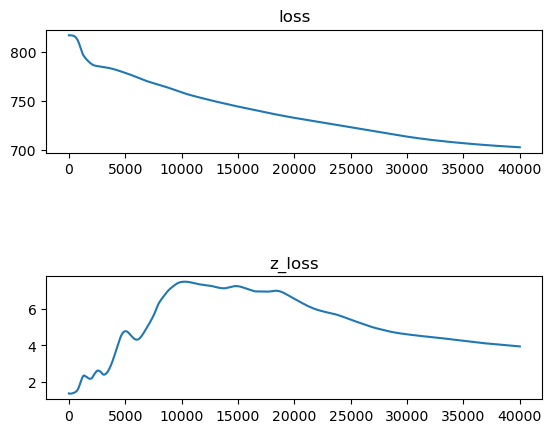

In [15]:
if save_params == True:
    saving(params)
plotting(loss_history,loss_z_history)